Swiss Institute for Banking and Finance,
University of St. Gallen,
Gianluca Vanacore

# SEC Webscraper

## Introduction

This notebook provides applicable code to parse SEC filing documents and to extract different content from it.
This code can be used for several inquiries ranging from competition to sentimental analyses.

The following code focuses on extracting financial data from the balance sheets, income statements or the cash flow statements.

In [2]:
# The libraries that we will be using are the following.

import time
from datetime import time
import numpy as np
import pandas as pd
import requests
import wrds
from bs4 import BeautifulSoup
from IPython.display import Image

## EDGAR Query

To create a query we need to construct the URL that takes us to the desired webpoint with the valid search results.
This requires us to taking a base endpoint and attaching on the desired parameters that are related to our query.

#### Endpoint
The endpoint for the EDGAR query is https://www.sec.gov/cgi-bin/browse-edgar

#### Parameters

- action: (required) By default should be set to getcompany.
- CIK: (required) Is the CIK number of the company you are searching.
- type: (optional) Allows filtering the type of form. For example, if set to 10-k only the 10-K filings are returned.
- dateb: (optional) Will only return the filings before a given date. The format is as follows YYYYMMDD
- owner: (required) Is set to exclude by default and specifies ownership. You may also set it to include and only.
- start: (optional) Is the starting index of the results. For example, if I have 100 results but want to start at 45 of 100, I would pass 45.
- state: (optional) The company's state.
- filenum: (optional) The filing number.
- sic: (optional) The company's SIC (Standard Industry Classification) identifier
- output: (optional) Defines returned data structure as either xml (atom) or normal html.
- count: (optional) The number of results you want to see with your request, the max is 100 and if not set it will default to 40.

Now that we understand all parameters, we can create our query that makes a HTTP request with the desired parameters.

The goal of the first function is to construct the urls of the desired filing types and return them in a list.
We do so by taking the endpoint as base URL and passing the desired parameters to make a HTTP request.
We then further check all search results, whether the filing type corresponds our query (since for e.g. 10-K queries
we would get 10-K/A as well, however for our financial numbers only 10-K are of interest).

### 1. Function:        find_filing_urls(cik, filing_type)

**Arguments**

- **cik**: Central index key used on SEC's computer systems to identify companies (e.g.: '0000789019')
- **filing_type**: Desired SEC filing type (e.g.: '10-K', '10-Q', '8-K').


- **return**:        List of filing urls

In [3]:
    def find_filing_urls(cik, filing_type):

        filing_urls = []

        endpoint = r"https://www.sec.gov/cgi-bin/browse-edgar"
        param_dict = {'action': 'getcompany',
                      'CIK': f'{cik}',
                      'type': f'{filing_type}',
                      'owner': 'exclude',
                      'output': 'atom'}

        response = requests.get(url=endpoint, params=param_dict)
        soup = BeautifulSoup(response.content, 'lxml')
        entries = soup.find_all('entry')

        for entry in entries:
            if entry.find('filing-type').text == str(filing_type):
                filing_urls.append(entry.find('link')['href'])

        return filing_urls

We can try the function with an example.
Let our company be Microsoft Corp (NASDQ: MSFT, CIK: 0000789019) and let us search all available 10-Ks on the SEC website.

In [4]:
    filing_urls = find_filing_urls('0000789019', '10-K')
    filing_urls

['https://www.sec.gov/Archives/edgar/data/789019/000156459020034944/0001564590-20-034944-index.htm',
 'https://www.sec.gov/Archives/edgar/data/789019/000156459019027952/0001564590-19-027952-index.htm',
 'https://www.sec.gov/Archives/edgar/data/789019/000156459018019062/0001564590-18-019062-index.htm',
 'https://www.sec.gov/Archives/edgar/data/789019/000156459017014900/0001564590-17-014900-index.htm',
 'https://www.sec.gov/Archives/edgar/data/789019/000119312516662209/0001193125-16-662209-index.htm',
 'https://www.sec.gov/Archives/edgar/data/789019/000119312515272806/0001193125-15-272806-index.htm',
 'https://www.sec.gov/Archives/edgar/data/789019/000119312514289961/0001193125-14-289961-index.htm',
 'https://www.sec.gov/Archives/edgar/data/789019/000119312513310206/0001193125-13-310206-index.htm',
 'https://www.sec.gov/Archives/edgar/data/789019/000119312512316848/0001193125-12-316848-index.htm',
 'https://www.sec.gov/Archives/edgar/data/789019/000119312511200680/0001193125-11-200680-in

Our function gives us a list of filing URLs. They correspond to the search results of the following EDGAR query.

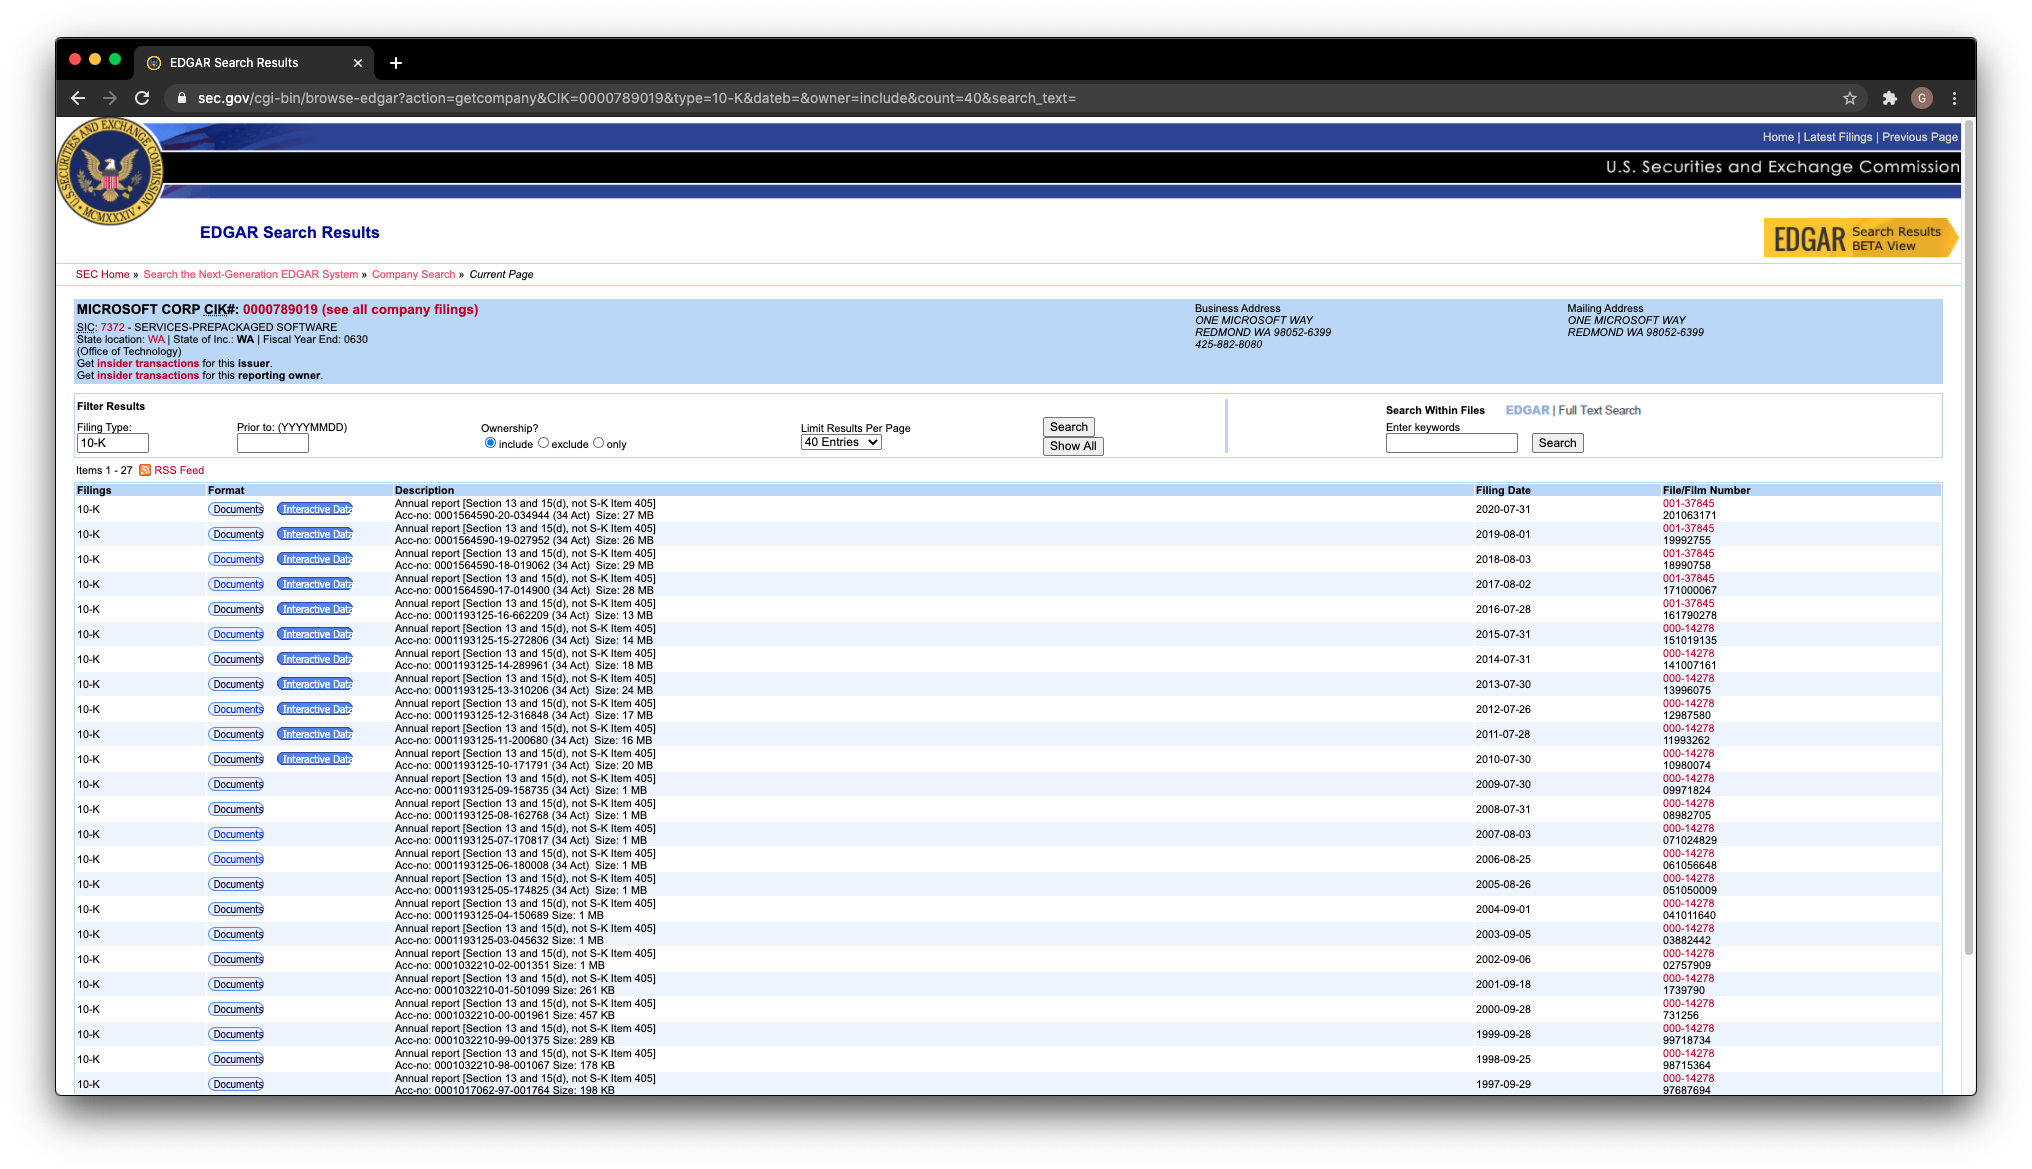

In [5]:
Image("EDGAR query.png")
#<img align="center" style="max-width: 900px; height: auto" src="/Users/gianluca/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Swiss Institute of Banking and Finance/SEC_Filings/Jupyter Notebook/EDGAR query.png">

## Finding the documents

Our collection of URLs contains now the links for all existent filings corresponding to our query.
Now we need to find the main document for each filing. The main document contains all information that is available for a specific filing.
It contains all the financial data such as balance sheets, income statements and cash flow statements. But also textual information is available.
In order to understand where we can find this main document, we should have a look at the HTML webpage that is sent to us when we open one of our filing URLs.

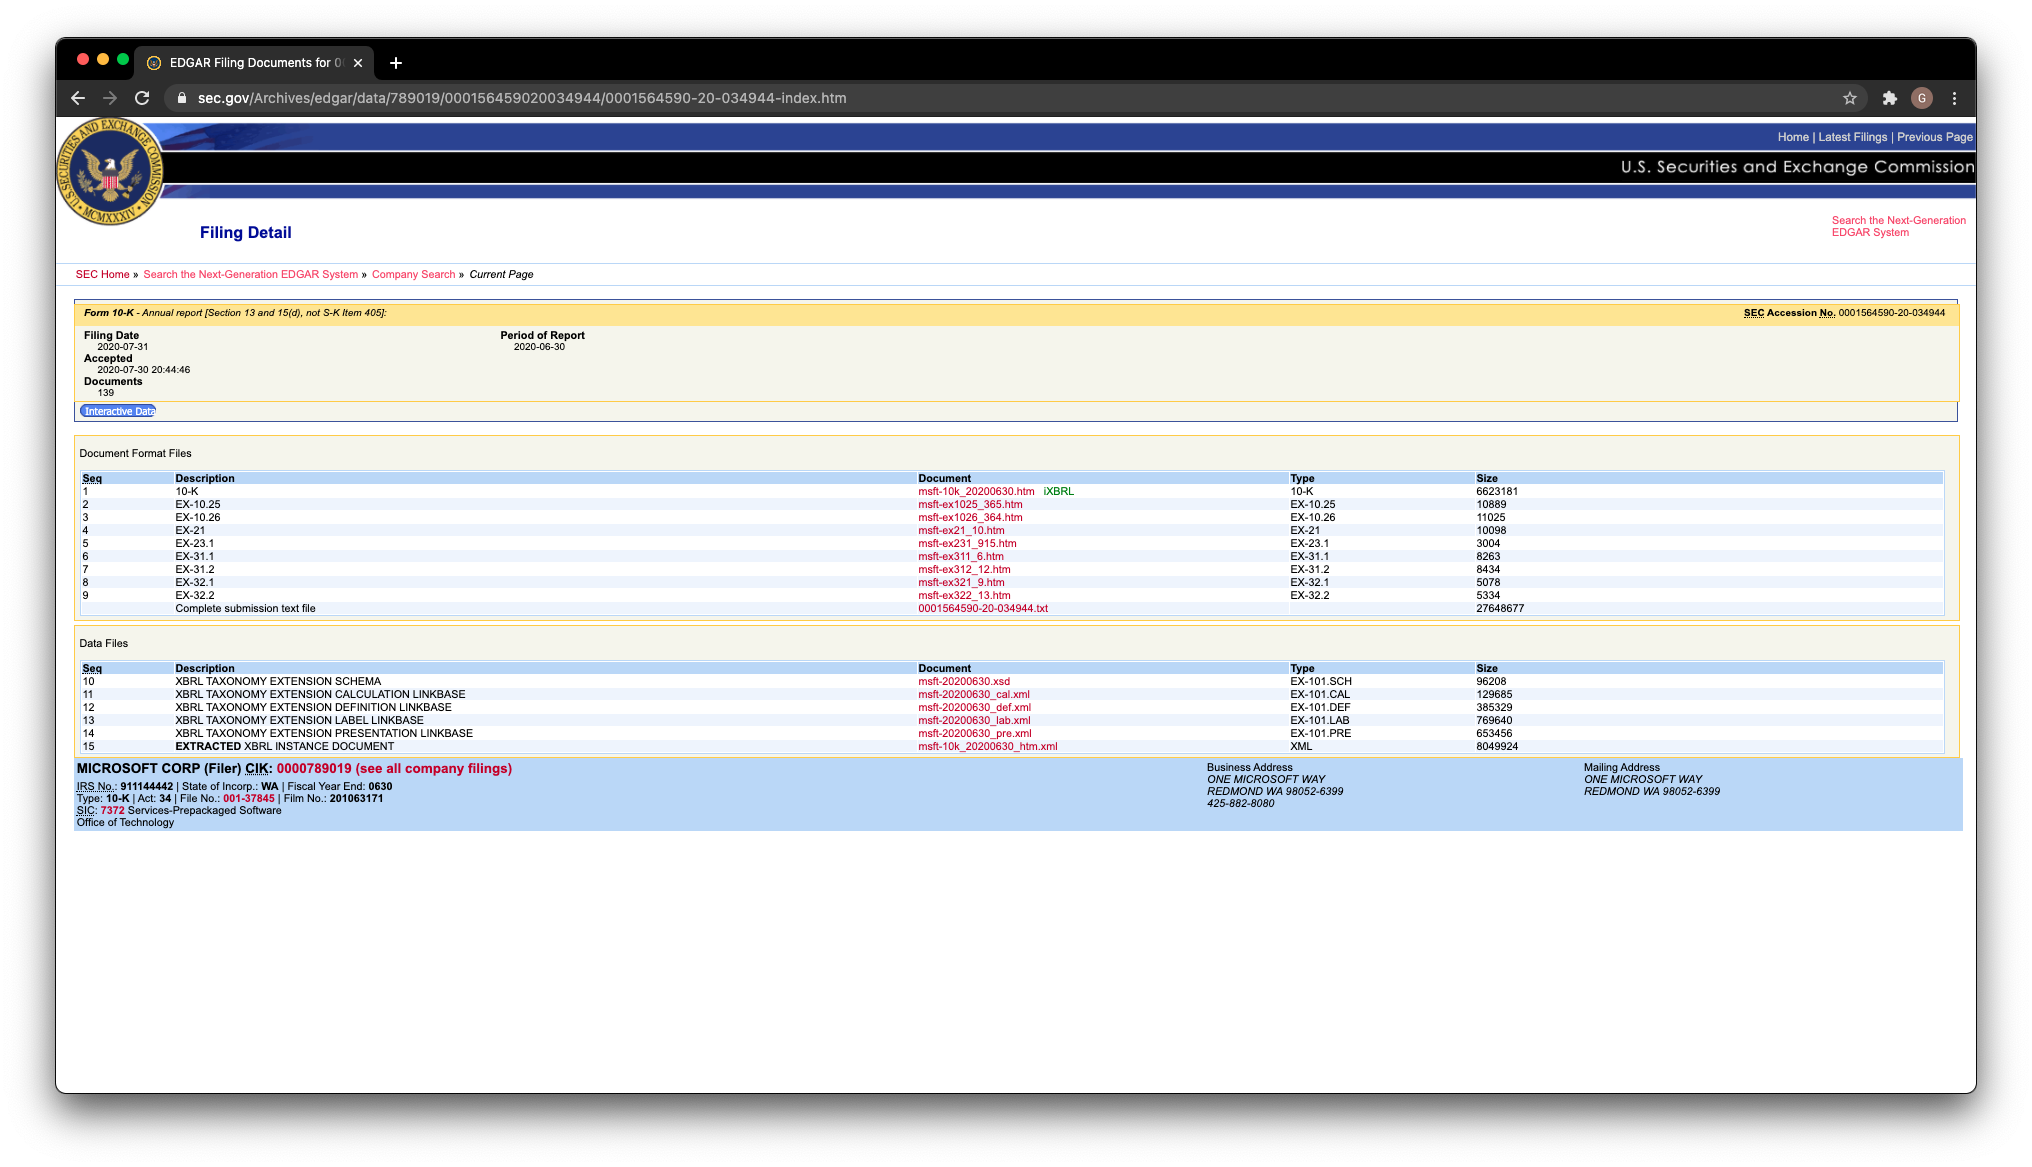

In [6]:
Image('Filing URL.png')

The information that we want to parse is located in the first row of the first table.
It turns out that this location is universal for most of the filings.
In some cases however, the document is located in the last row of the first table.
For our code, we take this alternate position into account when we do not find any document in our first row.

Therefore, our second function takes the filing URLs as arguments and returns the URLs of the main documents in a list.

### 2. Function:        find_document_urls(filing_urls)

**Arguments**

- **filing_urls**: List of collected filing_urls


- **return**: List of document urls

In [ ]:
    def find_document_urls(filing_urls):

        document_urls = []

        for url in filing_urls:
            ## for urls with html doc
            df = pd.read_html(url)[0]
            name = df[df['Type'].str.contains('10-K').fillna(False)]
            name = name['Document'].str.split(' ')

            ## targetting the complete submission .txt file
            if not name.fillna(False).any():
                name = df[df['Description'].str.contains('Complete').fillna(False)]
                name = name['Document'].str.split(' ')
                name = name.values[0][0]

            else:
                name = name[0][0]

            document_url = url.rsplit('/',1)[0] + '/' + name
            document_urls.append(document_url)

        return document_urls

    document_urls = find_document_urls(filing_urls)
    document_urls


## Finding the statements

At this point, it is important to note that the main documents contain an extreme amount of information which we can parse.
The following section is concerned with extracting the balance sheets, income statements and cash flow statements.
Our next function parses the whole document and extracts all available tables.
In a second step, the code extracts the tables that contain a certain signal word corresponding to which statement we are looking for.

### 3. Function:      find_raw_statements(document_urls, statement_type)

**Arguments**
- **document_urls**: List of collected document urls
- **statement_type**: Statement to be searched for ('balance_sheet', 'income_statement', 'cashflow_statement')

**Return**: List of raw statements which contain the specified signal word

In [ ]:
    def find_raw_statements(document_urls, statement_type):
        # Set signal words according to the passed statement type
        if statement_type == 'balance_sheet':
            signal1 = 'Total current assets'
            signal2 = 'Total current liabilities'
    
        elif statement_type == 'income_statement':
            signal1 = 'Net income'
            signal2 = 'Weighted-average shares'
    
        elif statement_type == 'cashflow_statement':
            signal1 = 'financing activities'
            signal2 = 'Operations'
    
        else:
            print('Pass valid statement type (balance_sheet/income_statement/cashflow_statement).')
            return
        # Initializing a list for our collection
        raw_statements = []
        # Separating the collected documents into html and txt files (only html files can be parsed)
        htms = [x for x in document_urls if x.endswith('htm')]
        txts = [x for x in document_urls if x.endswith('txt')]
    
        print(f'Number of documents to be processed: {len(htms)}')
        # Iterators to indicate current position of the parser
        i = 1
        u = 1
        # Keeping track of the computing time
        starttime = time.time()
    
        for document in htms:
            # Parsing all tables
            dfs = pd.read_html(document)
    
            for statement in dfs:
                # Identifying tables that contain the signal word in their first column
                try:
                    BS = statement[0].astype(str).str.contains(signal1)
                except (KeyError):
                    continue
                # If table found: Append it to our collection
                if BS.any():
                    raw_statements.append(statement)
                    currenttime = time.time() - starttime
                    print(f'Document {u} | {i}. statement found | time: {currenttime}')
                    i += 1
    
            u += 1
    
        return raw_statements

    raw_statements = find_raw_statements(document_urls, 'balance_sheet')
    raw_statements

## Cleaning the statements

Now that we have all balance sheets for our company in a raw format.
To extract information from it we first have to clean the raw statements and bring them into a uniform format.

### 4. Function: format_statements(raw_statements)

**Arguments**

**raw_statements**: List of raw statements

**Return**: List of clean and uniform statements

In [2]:
    def format_statements(raw_statements):
        # Initzialize list for our collection
        clean_statements = []

        for raw_statement in raw_statements:
            raw_statement = raw_statement.loc[:, raw_statement.isin(['$']).mean() < .5] # Delete columns that contain mostly '$'
            raw_statement = raw_statement.loc[:, raw_statement.isnull().mean() < .5] # Delete columns that contain mostly 'np.nan'
            raw_statement = raw_statement.dropna(axis=0, how='all') # Delete rows that contain 'np.nan'
            raw_statement.reset_index(inplace=True, drop=True)
            clean_statement = raw_statement[2:].astype(str) # Create a clean_statement

            try:
                years = raw_statement.iloc[1,:].values[1:].tolist() # Collect the financial years
                date = raw_statement.iloc[1, 0] # Collect the dates on which the financial  
                # Some workarounds if the years where not in the second row
                if np.nan in years:
                    years = raw_statement.iloc[0,:].values[1:].tolist()
                if all(x == years[0] for x in years):
                    years = raw_statement.iloc[0,:].values[1:].tolist()
                if (('As\xa0Restated(1)' in years) or ('As\xa0Restated' in years)):
                    years = raw_statement.iloc[0, :].values[1:].tolist()
                column_list = years # Specify a column list

            except (IndexError):
                continue
            # Clean the strings of our column list
            column_list = [str(i) for i in column_list]
            column_list = [str(i.split('(')[0]) for i in column_list]
            column_list = [str(i.split('.')[0]) for i in column_list]
            # Still cleaning
            for i in column_list[1:]: # Keep dates

                if (len(i.split(', ')) > 1):
                    sign = True
                elif (len(i.split(', ')) <= 1):
                    sign = False
                    break

            if sign == True:
                column_list = [str(i.split(', ')[1]) for i in column_list[1:]]
            # Still cleaning
            for i in column_list[1:]:

                if (len(i.split(',')) > 1):
                    sign = True
                elif (len(i.split(',')) <= 1):
                    sign = False
                    break

            if sign == True:
                column_list = [str(i.split(',')[1]) for i in column_list[1:]]
            # Still cleaning
            for i in column_list[1:]:

                if (len(i.split('\xa0')) > 1):
                    sign = True
                elif (len(i.split('\xa0')) <= 1):
                    sign = False
                    break

            if sign == True:
                column_list = [str(i.split('\xa0')[-1]) for i in column_list[1:]]
            # Add a new column
            column_list = ['Financial position'] + column_list
            # Set the columns in our clean statement
            clean_statement.columns = column_list
            clean_statement.reset_index(inplace=True, drop=True)
            # Delete duplicated columns
            BS = clean_statement.columns.duplicated()
            if BS.any():
                clean_statement = clean_statement.loc[:, [True] + list(clean_statement.columns.duplicated())[1:]]

            try: # Clean the strings in the first column
                clean_statement[column_list[0]] = clean_statement[column_list[0]].map(lambda x: x.replace('\x92', "'"))
                clean_statement[column_list[0]] = clean_statement[column_list[0]].map(lambda x: x.replace('\xa0', " "))
                clean_statement[column_list[0]] = clean_statement[column_list[0]].map(lambda x: x.replace('’', "'"))

            except (ValueError):
                continue

            if all(x == clean_statement.columns[1] for x in clean_statement.columns[1:]):
                continue
            # Clean the strings in all columns
            try:
                for i in clean_statement.columns[1:]:
                    clean_statement[i] = clean_statement[i].map(lambda x: x.replace('(', '-'))
                    clean_statement[i] = clean_statement[i].map(lambda x: x.replace(',', ''))
                    clean_statement[i] = clean_statement[i].map(lambda x: x.replace('—', '0'))
                    clean_statement[i] = clean_statement[i].map(lambda x: x.replace('\x96', '0'))
                    clean_statement[i] = clean_statement[i].map(lambda x: x.replace('\x97', '0'))
                    # Convert the numbers first from string to floats
                    # Then from floats to integers
                    clean_statement[i] = pd.to_numeric(clean_statement[i], errors='coerce')
                    clean_statement[i] = clean_statement[i].astype('Int64')

            except (AttributeError):
                continue
            # Add an additional column
            clean_statement['Financial year ends on this date'] = date.replace(',','').replace('\xa0', ' ')
            # Add a binary variable
            if (('Million' in raw_statement.iloc[0,0]) or ('million' in raw_statement.iloc[0,0])):
                clean_statement['Binary: Numbers in millions'] = 1
            else:
                clean_statement['Binary: Numbers in millions'] = 0

            clean_statements.append(clean_statement)

        return clean_statements
    
    clean_statements = format_statements(raw_statements)
    clean_statements

NameError: name 'raw_statements' is not defined

## Extract data

Now that we have clean financial statements we can access the data. The next function takes our desired variable and returns a time series. Alternative spelling of the same financial position is taken into account.

#### 5. Function: create_variable_dataframe(clean_statements, var, var_alt_spelling1 = None, var_alt_spelling2 = None)

**Arguments**

**clean_statements**: List of clean statements

**var**: Desired variable

**var_alt_spelling1**: 1. Alternative spelling of same variable (defaults to None)
**var_alt_spelling2**: 2. Alternative spelling of same variable (defaults to None)

**Return**: Time series as dataframe with numeric values of the variable and date as index

In [ ]:
def create_variable_dataframe(clean_statements, var, var_alt_spelling1 = None, var_alt_spelling2 = None):
    # Initizializing a dataframe
    variable_dataframe = pd.DataFrame()

    for clean_statement in clean_statements:

        for index, row in clean_statement.iterrows():
            # Search the financial position that correspond to our passed variable
            if row.values[0] == var:
                # Take the values and set the columns (years) as index in our new dataframe
                variable_data = row.values[1:]
                variable_df = pd.DataFrame(variable_data, index=clean_statement.columns[1:])
                variable_dataframe = pd.concat([variable_dataframe, variable_df])
            # Check alternative spelling of our variable
            if not var_alt_spelling1 == None:

                if row.values[0] == var_alt_spelling1:

                    variable_data = row.values[1:]
                    variable_df = pd.DataFrame(variable_data, index=clean_statement.columns[1:])
                    variable_dataframe = pd.concat([variable_dataframe, variable_df])
            # Check alternative spelling of our variable
            if not var_alt_spelling2 == None:

                if row.values[0] == var_alt_spelling2:

                    variable_data = row.values[1:]
                    variable_df = pd.DataFrame(variable_data, index=clean_statement.columns[1:])
                    variable_dataframe = pd.concat([variable_dataframe, variable_df])
    # Delete duplicated rows
    variable_dataframe = variable_dataframe[~ variable_dataframe.index.duplicated()]
    # Sort the time series with respect to the year
    variable_dataframe = variable_dataframe.sort_index(ascending=False)

    return variable_dataframe

variable_dataframe = create_variable_dataframe(clean_statements, 'Total Assets')
variable_dataframe

In [3]:
def create_variable_dataframe(clean_statements, var, var_alt_spelling1 = None, var_alt_spelling2 = None):
    # Initizializing a dataframe
    variable_dataframe = pd.DataFrame()

    for clean_statement in clean_statements:

        for index, row in clean_statement.iterrows():
            # Search the financial position that correspond to our passed variable
            if row.values[0] == var:
                # Take the values and set the columns (years) as index in our new dataframe
                variable_data = row.values[1:]
                variable_df = pd.DataFrame(variable_data, index=clean_statement.columns[1:])
                variable_dataframe = pd.concat([variable_dataframe, variable_df])
            # Check alternative spelling of our variable
            if not var_alt_spelling1 == None:

                if row.values[0] == var_alt_spelling1:

                    variable_data = row.values[1:]
                    variable_df = pd.DataFrame(variable_data, index=clean_statement.columns[1:])
                    variable_dataframe = pd.concat([variable_dataframe, variable_df])
            # Check alternative spelling of our variable
            if not var_alt_spelling2 == None:

                if row.values[0] == var_alt_spelling2:

                    variable_data = row.values[1:]
                    variable_df = pd.DataFrame(variable_data, index=clean_statement.columns[1:])
                    variable_dataframe = pd.concat([variable_dataframe, variable_df])
    # Delete duplicated rows
    variable_dataframe = variable_dataframe[~ variable_dataframe.index.duplicated()]
    # Sort the time series with respect to the year
    variable_dataframe = variable_dataframe.sort_index(ascending=False)

    return variable_dataframe

variable_dataframe = create_variable_dataframe(clean_statements, 'Total Assets')
variable_dataframe

NameError: name 'clean_statements' is not defined